# install

In [ ]:
#ライブラリのインポート

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import random
import copy
from tqdm import tqdm
import os
import datetime
import pytz
from scipy.stats import entropy
from polyagamma import random_polyagamma

# 実装した関数のインポート

from function import *

# ベイズリスク実験_$P(Z|X)$：打ち切り型

In [ ]:
# X_mu
X_mu_list = [-5,-2,0,2,5]

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^nのn)
sample = 100

# サンプル個数（centerを何箇所設定するか）
num_center = 10

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001]) # ここ0より大きい必要あり

# betaの事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 2000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[1, 0], [0, 1]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)


for num, X_mu in enumerate(X_mu_list):
    
        # KL格納リスト
        KL_matrix_sample = np.array([])
        KL_matrix_logistic = np.array([])
        KL_matrix_estimator = np.array([])

        for beta0,beta1 in tqdm(beta_list):

                # \tilde{D}^Nの生成
                df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

                # 真のp計算
                p_true = df["Y"].mean()

                # サンプル位置ごとにfor loop

                # サンプル始点
                lower = -5

                # サンプル終点
                upper = 5

                for center in np.linspace(lower, upper, num_center):

                        # D^nの生成
                        df_sample = sampler_cut(df, center, window)
                        
                        #最初のn数分だけ抽出
                        df_sample = df_sample[:sample]

                        # pを推定
                        p_sample = df_sample["Y"].mean()
                        
                        # 真の分布からXを発生させておく（ロジスティック回帰と提案手法のモンテカルロ積分用）
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        
                        # Yが1クラスしかない場合にスキップする
                        if df_sample["Y"].nunique() == 2:
                        
                                # 最尤法
                                model = LogisticRegression(penalty = None)

                                # Xの形状を調整（sklearnの入力は2次元配列を期待するため）
                                X_logistic = df_sample['X'].values.reshape(-1, 1)
                                Y_logistic = df_sample['Y']

                                # モデルを学習
                                model.fit(X_logistic, Y_logistic)

                                # パラメータ(切片と係数)を取得
                                intercept = model.intercept_[0]  # 切片
                                coef = model.coef_[0][0]  # 係数

                                # パラメータ行列を作成
                                vector = np.array([[intercept, coef]])
                                beta_matrix_logostic = np.repeat(vector, draw, axis=0)

                                # pを計算                                
                                p_estimator_all_logistic = sigmoid(X_true, beta_matrix_logostic)
                                p_estimator_logistic = np.mean(p_estimator_all_logistic)
                                
                        else:
                                p_estimator_all_logistic = np.full(draw, np.nan)
                                p_estimator_logistic = df_sample["Y"].mean()
                        
                        # 提案手法
                        beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        p_estimator_all = sigmoid(X_true, beta_posterior)
                        p_estimator = np.mean(p_estimator_all)

                        # KLを計算
                        KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))
                        KL_matrix_logistic = np.append(KL_matrix_logistic, KLD(p_estimator_logistic,p_true))
                        KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

        print(KL_matrix_logistic.shape)
        # KL行列を変形して，平均
        KL_list_sample = np.mean(KL_matrix_sample.reshape(Ex_num, num_center), axis = 0)
        KL_list_logistic = np.mean(KL_matrix_logistic.reshape(Ex_num, num_center), axis = 0)
        KL_list_estimator = np.mean(KL_matrix_estimator.reshape(Ex_num, num_center), axis = 0)

        # グラフ描画
        plt.plot(np.linspace(lower, upper, num_center), KL_list_sample, label="sample mean", color = "blue",marker='.',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_logistic, label="logistic regression", color = "green",marker='o',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_estimator, label="Proposed method", color = "red",marker='*',markersize=12)

        plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(1,1)".format(X_mu, X_sigma), fontsize = 12)
        plt.xlabel("center of sampling", fontsize = 12)
        plt.ylabel("BayesRisk(Average KL Divergence)", fontsize = 12)

        plt.xlim(lower-0.5, upper+0.5)

        plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

        save_dir = make_now_dir("../graph")

        plt.savefig("{}/BayesRisk_Xmu_{}_Xsigma_{}_size_{}.png".format(save_dir,X_mu,X_sigma,sample))
        
        plt.clf()

$\beta$の真の分布の分散を大きくする

In [ ]:
# X_mu
X_mu_list = [-5,-2,0,2,5]

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^nのn)
sample = 100

# サンプル個数（centerを何箇所設定するか）
num_center = 10

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001]) # ここ0より大きい必要あり

# betaの事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 2000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[3, 0], [0, 3]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)


for num, X_mu in enumerate(X_mu_list):
    
        # KL格納リスト
        KL_matrix_sample = np.array([])
        KL_matrix_logistic = np.array([])
        KL_matrix_estimator = np.array([])

        for beta0,beta1 in tqdm(beta_list):

                # \tilde{D}^Nの生成
                df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

                # 真のp計算
                p_true = df["Y"].mean()

                # サンプル位置ごとにfor loop

                # サンプル始点
                lower = -5

                # サンプル終点
                upper = 5

                for center in np.linspace(lower, upper, num_center):

                        # D^nの生成
                        df_sample = sampler_cut(df, center, window)
                        
                        #最初のn数分だけ抽出
                        df_sample = df_sample[:sample]

                        # pを推定
                        p_sample = df_sample["Y"].mean()
                        
                        # 真の分布からXを発生させておく（ロジスティック回帰と提案手法のモンテカルロ積分用）
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        
                        # Yが1クラスしかない場合にスキップする
                        if df_sample["Y"].nunique() == 2:
                        
                                # 最尤法
                                model = LogisticRegression(penalty = None)

                                # Xの形状を調整（sklearnの入力は2次元配列を期待するため）
                                X_logistic = df_sample['X'].values.reshape(-1, 1)
                                Y_logistic = df_sample['Y']

                                # モデルを学習
                                model.fit(X_logistic, Y_logistic)

                                # パラメータ(切片と係数)を取得
                                intercept = model.intercept_[0]  # 切片
                                coef = model.coef_[0][0]  # 係数

                                # パラメータ行列を作成
                                vector = np.array([[intercept, coef]])
                                beta_matrix_logostic = np.repeat(vector, draw, axis=0)

                                # pを計算                                
                                p_estimator_all_logistic = sigmoid(X_true, beta_matrix_logostic)
                                p_estimator_logistic = np.mean(p_estimator_all_logistic)
                                
                        else:
                                p_estimator_all_logistic = np.full(draw, np.nan)
                                p_estimator_logistic = df_sample["Y"].mean()
                        
                        # 提案手法
                        beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        p_estimator_all = sigmoid(X_true, beta_posterior)
                        p_estimator = np.mean(p_estimator_all)

                        # KLを計算
                        KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))
                        KL_matrix_logistic = np.append(KL_matrix_logistic, KLD(p_estimator_logistic,p_true))
                        KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

        print(KL_matrix_logistic.shape)
        # KL行列を変形して，平均
        KL_list_sample = np.mean(KL_matrix_sample.reshape(Ex_num, num_center), axis = 0)
        KL_list_logistic = np.mean(KL_matrix_logistic.reshape(Ex_num, num_center), axis = 0)
        KL_list_estimator = np.mean(KL_matrix_estimator.reshape(Ex_num, num_center), axis = 0)

        # グラフ描画
        plt.plot(np.linspace(lower, upper, num_center), KL_list_sample, label="sample mean", color = "blue",marker='.',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_logistic, label="logistic regression", color = "green",marker='o',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_estimator, label="Proposed method", color = "red",marker='*',markersize=12)

        plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(1,1)".format(X_mu, X_sigma), fontsize = 12)
        plt.xlabel("center of sampling", fontsize = 12)
        plt.ylabel("BayesRisk(Average KL Divergence)", fontsize = 12)

        plt.xlim(lower-0.5, upper+0.5)

        plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

        save_dir = make_now_dir("../graph")

        plt.savefig("{}/BayesRisk_Xmu_{}_Xsigma_{}_size_{}.png".format(save_dir,X_mu,X_sigma,sample))
        
        plt.clf()

標本平均をなくして，最尤法と提案手法を細かく比較

In [ ]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu_list = [-5,-2,0,2,5]

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^nのn)
sample = 100

# サンプル個数（centerを何箇所設定するか）
num_center = 10

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001]) # ここ0より大きい必要あり

# betaの事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 2000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[1, 0], [0, 1]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)


for num, X_mu in enumerate(X_mu_list):
    
        # KL格納リスト
        KL_matrix_sample = np.array([])
        KL_matrix_logistic = np.array([])
        KL_matrix_estimator = np.array([])

        for beta0,beta1 in tqdm(beta_list):

                # \tilde{D}^Nの生成
                df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

                # 真のp計算
                p_true = df["Y"].mean()

                # サンプル位置ごとにfor loop

                # サンプル始点
                lower = -5

                # サンプル終点
                upper = 5

                for center in np.linspace(lower, upper, num_center):

                        # D^nの生成
                        df_sample = sampler_cut(df, center, window)
                        
                        #最初のn数分だけ抽出
                        df_sample = df_sample[:sample]
                        
                        """
                        # pを推定
                        p_sample = df_sample["Y"].mean()
                        
                        """
                        
                        # 真の分布からXを発生させておく（ロジスティック回帰と提案手法のモンテカルロ積分用）
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        
                        # Yが1クラスしかない場合にスキップする
                        if df_sample["Y"].nunique() == 2:
                        
                                # 最尤法
                                model = LogisticRegression(penalty = None)

                                # Xの形状を調整（sklearnの入力は2次元配列を期待するため）
                                X_logistic = df_sample['X'].values.reshape(-1, 1)
                                Y_logistic = df_sample['Y']

                                # モデルを学習
                                model.fit(X_logistic, Y_logistic)

                                # パラメータ(切片と係数)を取得
                                intercept = model.intercept_[0]  # 切片
                                coef = model.coef_[0][0]  # 係数

                                # パラメータ行列を作成
                                vector = np.array([[intercept, coef]])
                                beta_matrix_logostic = np.repeat(vector, draw, axis=0)

                                # pを計算                                
                                p_estimator_all_logistic = sigmoid(X_true, beta_matrix_logostic)
                                p_estimator_logistic = np.mean(p_estimator_all_logistic)
                                
                        else:
                                p_estimator_all_logistic = np.full(draw, np.nan)
                                p_estimator_logistic = df_sample["Y"].mean()
                        
                        # 提案手法
                        beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        p_estimator_all = sigmoid(X_true, beta_posterior)
                        p_estimator = np.mean(p_estimator_all)

                        # KLを計算
                        # KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))
                        KL_matrix_logistic = np.append(KL_matrix_logistic, KLD(p_estimator_logistic,p_true))
                        KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

        # KL行列を変形して，平均
        # KL_list_sample = np.mean(KL_matrix_sample.reshape(Ex_num, num_center), axis = 0)
        KL_list_logistic = np.mean(KL_matrix_logistic.reshape(Ex_num, num_center), axis = 0)
        KL_list_estimator = np.mean(KL_matrix_estimator.reshape(Ex_num, num_center), axis = 0)

        # グラフ描画
        # plt.plot(np.linspace(lower, upper, num_center), KL_list_sample, label="sample mean", color = "blue",marker='.',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_logistic, label="logistic regression", color = "green",marker='o',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_estimator, label="Proposed method", color = "red",marker='*',markersize=12)

        plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(1,1)".format(X_mu, X_sigma), fontsize = 12)
        plt.xlabel("center of sampling", fontsize = 12)
        plt.ylabel("BayesRisk(Average KL Divergence)", fontsize = 12)

        plt.xlim(lower-0.5, upper+0.5)

        plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

        plt.savefig("{}/BayesRisk_Xmu_{}_Xsigma_{}_size_{}.png".format(save_dir,X_mu,X_sigma,sample))
        
        plt.clf()

βの真の分布の分散を大きくして，提案手法有利にする

In [ ]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu_list = [-5,-2,0,2,5]

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^nのn)
sample = 100

# サンプル個数（centerを何箇所設定するか）
num_center = 10

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001]) # ここ0より大きい必要あり

# betaの事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 2000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[3, 0], [0, 3]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)


for num, X_mu in enumerate(X_mu_list):
    
        # KL格納リスト
        KL_matrix_sample = np.array([])
        KL_matrix_logistic = np.array([])
        KL_matrix_estimator = np.array([])

        for beta0,beta1 in tqdm(beta_list):

                # \tilde{D}^Nの生成
                df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

                # 真のp計算
                p_true = df["Y"].mean()

                # サンプル位置ごとにfor loop

                # サンプル始点
                lower = -5

                # サンプル終点
                upper = 5

                for center in np.linspace(lower, upper, num_center):

                        # D^nの生成
                        df_sample = sampler_cut(df, center, window)
                        
                        #最初のn数分だけ抽出
                        df_sample = df_sample[:sample]
                        
                        """
                        # pを推定
                        p_sample = df_sample["Y"].mean()
                        
                        """
                        
                        # 真の分布からXを発生させておく（ロジスティック回帰と提案手法のモンテカルロ積分用）
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        
                        # Yが1クラスしかない場合にスキップする
                        if df_sample["Y"].nunique() == 2:
                        
                                # 最尤法
                                model = LogisticRegression(penalty = None)

                                # Xの形状を調整（sklearnの入力は2次元配列を期待するため）
                                X_logistic = df_sample['X'].values.reshape(-1, 1)
                                Y_logistic = df_sample['Y']

                                # モデルを学習
                                model.fit(X_logistic, Y_logistic)

                                # パラメータ(切片と係数)を取得
                                intercept = model.intercept_[0]  # 切片
                                coef = model.coef_[0][0]  # 係数

                                # パラメータ行列を作成
                                vector = np.array([[intercept, coef]])
                                beta_matrix_logostic = np.repeat(vector, draw, axis=0)

                                # pを計算                                
                                p_estimator_all_logistic = sigmoid(X_true, beta_matrix_logostic)
                                p_estimator_logistic = np.mean(p_estimator_all_logistic)
                                
                        else:
                                p_estimator_all_logistic = np.full(draw, np.nan)
                                p_estimator_logistic = df_sample["Y"].mean()
                        
                        # 提案手法
                        beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        p_estimator_all = sigmoid(X_true, beta_posterior)
                        p_estimator = np.mean(p_estimator_all)

                        # KLを計算
                        # KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))
                        KL_matrix_logistic = np.append(KL_matrix_logistic, KLD(p_estimator_logistic,p_true))
                        KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

        # KL行列を変形して，平均
        # KL_list_sample = np.mean(KL_matrix_sample.reshape(Ex_num, num_center), axis = 0)
        KL_list_logistic = np.mean(KL_matrix_logistic.reshape(Ex_num, num_center), axis = 0)
        KL_list_estimator = np.mean(KL_matrix_estimator.reshape(Ex_num, num_center), axis = 0)

        # グラフ描画
        # plt.plot(np.linspace(lower, upper, num_center), KL_list_sample, label="sample mean", color = "blue",marker='.',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_logistic, label="logistic regression", color = "green",marker='o',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_estimator, label="Proposed method", color = "red",marker='*',markersize=12)

        plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(1,1)".format(X_mu, X_sigma), fontsize = 12)
        plt.xlabel("center of sampling", fontsize = 12)
        plt.ylabel("BayesRisk(Average KL Divergence)", fontsize = 12)

        plt.xlim(lower-0.5, upper+0.5)

        plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

        plt.savefig("{}/BayesRisk_Xmu_{}_Xsigma_{}_size_{}.png".format(save_dir,X_mu,X_sigma,sample))
        
        plt.clf()

# サンプルサイズ実験_$P(Z|X)$：打ち切り型

標本平均

100%|█████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


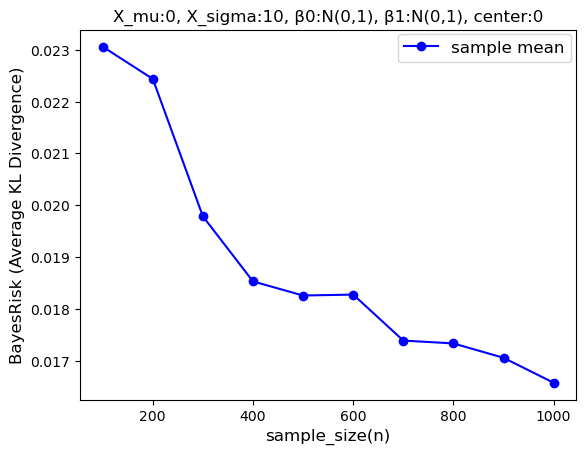

In [19]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^NのN)
sample_list = np.linspace(100,1000,10)

# サンプル位置
# サンプル始点
lower = -5
# サンプル終点
upper = 5
center = 0

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001])

# beta0の事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 1000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[3, 0], [0, 3]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)

# KL格納リスト

KL_matrix_sample = np.array([])
KL_matrix_estimator = np.array([])

for beta0,beta1 in tqdm(beta_list):

        # \tilde{D}^Nの生成
        df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

        # Zの生成
        df.loc[(df["X"]<center+window)&(df["X"]>center-window),"Z"] = 1

        # Z=1のみに絞る
        df_z1 = df.loc[df["Z"]==1]

        # 真のp計算
        p_true = df["Y"].mean() 

        # サンプルサイズごとに計算
        for sample in sample_list:

            # D^nの生成
            df_sample = df_z1[:sample.astype(int)]

            # 標本平均
            p_sample = df_sample["Y"].mean()
            KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))

# KL行列を変形
KL_matrix_sample_t = KL_matrix_sample.reshape(len(beta_list),len(sample_list))

# KL行列を平均
KL_mean_sample = np.mean(KL_matrix_sample_t,axis=0)

# グラフ描画
plt.plot(sample_list, KL_mean_sample, label="sample mean", color = "blue",marker='.',markersize=12)

plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(0,1), center:{}".format(X_mu, X_sigma,round(center,3)), fontsize = 12)
plt.xlabel("sample_size(n)", fontsize = 12)
plt.ylabel("BayesRisk (Average KL Divergence)", fontsize = 12)

plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         
 
plt.savefig("{}/BayesRisk-by-sample-size_sample-mean_Xmu_{}_Xsigma_{}.png".format(save_dir,X_mu,X_sigma))       

最尤推定

 39%|████████████████▍                         | 39/100 [03:04<04:18,  4.24s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
 95%|███████████████████████████████████████▉  | 95/100 [07:42<00:24,  4.83s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|█████████████████████████████████████████| 100/100 [08:06<00:00,  4.86s/it]


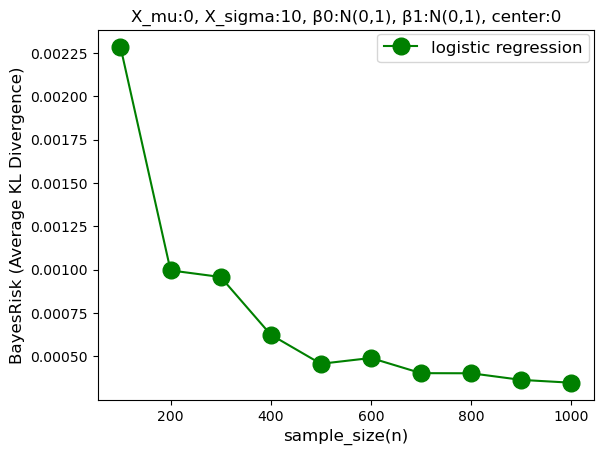

In [18]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^NのN)
sample_list = np.linspace(100,1000,10)

# サンプル位置
# サンプル始点
lower = -5
# サンプル終点
upper = 5
center = 0

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001])

# beta0の事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 1000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[3, 0], [0, 3]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)

# KL格納リスト

KL_matrix_sample = np.array([])
KL_matrix_logistic = np.array([])
KL_matrix_estimator = np.array([])

for beta0,beta1 in tqdm(beta_list):

        # \tilde{D}^Nの生成
        df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

        # Zの生成
        df.loc[(df["X"]<center+window)&(df["X"]>center-window),"Z"] = 1

        # Z=1のみに絞る
        df_z1 = df.loc[df["Z"]==1]

        # 真のp計算
        p_true = df["Y"].mean() 

        # サンプルサイズごとに計算
        for sample in sample_list:

            # D^nの生成
            df_sample = df_z1[:sample.astype(int)]

            # 真の分布からXを発生させておく（ロジスティック回帰と提案手法のモンテカルロ積分用）
            X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)

            # Yが1クラスしかない場合にスキップする
            if df_sample["Y"].nunique() == 2:

                    # 最尤法
                    model = LogisticRegression(penalty = None)

                    # Xの形状を調整（sklearnの入力は2次元配列を期待するため）
                    X_logistic = df_sample['X'].values.reshape(-1, 1)
                    Y_logistic = df_sample['Y']

                    # モデルを学習
                    model.fit(X_logistic, Y_logistic)

                    # パラメータ(切片と係数)を取得
                    intercept = model.intercept_[0]  # 切片
                    coef = model.coef_[0][0]  # 係数

                    # パラメータ行列を作成
                    vector = np.array([[intercept, coef]])
                    beta_matrix_logostic = np.repeat(vector, draw, axis=0)

                    # pを計算                                
                    p_estimator_all_logistic = sigmoid(X_true, beta_matrix_logostic)
                    p_estimator_logistic = np.mean(p_estimator_all_logistic)

            else:
                    p_estimator_all_logistic = np.full(draw, np.nan)
                    p_estimator_logistic = df_sample["Y"].mean()
            
            KL_matrix_logistic = np.append(KL_matrix_logistic, KLD(p_estimator_logistic,p_true))

# KL行列を変形
KL_list_logistic_t = KL_matrix_logistic.reshape(len(beta_list),len(sample_list))

# KL行列を平均
KL_mean_logistic = np.mean(KL_list_logistic_t,axis=0)

# グラフ描画
plt.plot(sample_list, KL_mean_logistic, label="logistic regression", color = "green",marker='o',markersize=12)

plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(0,1), center:{}".format(X_mu, X_sigma,round(center,3)), fontsize = 12)
plt.xlabel("sample_size(n)", fontsize = 12)
plt.ylabel("BayesRisk (Average KL Divergence)", fontsize = 12)

plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         
 
plt.savefig("{}/BayesRisk-by-sample-size_logistic_Xmu_{}_Xsigma_{}.png".format(save_dir,X_mu,X_sigma))       

提案手法

 56%|████████████████████▏               | 56/100 [31:26:28<1:58:30, 161.61s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
100%|████████████████████████████████████| 100/100 [32:45:23<00:00, 1179.23s/it]


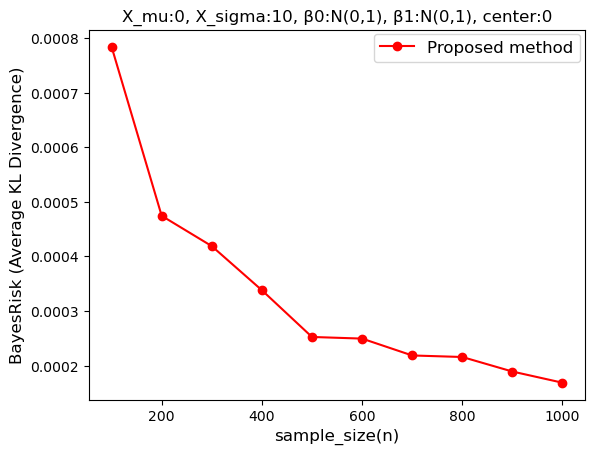

In [17]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^NのN)
sample_list = np.linspace(100,1000,10)

# サンプル位置
# サンプル始点
lower = -5
# サンプル終点
upper = 5
center = 0

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001])

# beta0の事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 1000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[1, 0], [0, 1]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)

# KL格納リスト

KL_matrix_sample = np.array([])
KL_matrix_estimator = np.array([])

for beta0,beta1 in tqdm(beta_list):

        # \tilde{D}^Nの生成
        df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

        # Zの生成
        df.loc[(df["X"]<center+window)&(df["X"]>center-window),"Z"] = 1

        # Z=1のみに絞る
        df_z1 = df.loc[df["Z"]==1]

        # 真のp計算
        p_true = df["Y"].mean() 

        # サンプルサイズごとに計算
        for sample in sample_list:

            # D^nの生成
            df_sample = df_z1[:sample.astype(int)]

            # D^nによるBOE
            beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
            X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
            p_estimator_all = sigmoid(X_true, beta_posterior)
            p_estimator = np.mean(p_estimator_all)
            KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

# KL行列を変形
KL_matrix_estimator_t = KL_matrix_estimator.reshape(len(beta_list),len(sample_list))

# KL行列を平均
KL_mean_estimator = np.mean(KL_matrix_estimator_t,axis=0)

# グラフ描画
plt.plot(sample_list, KL_mean_estimator, label="Proposed method", color = "red",marker='.',markersize=12)

plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(0,1), center:{}".format(X_mu, X_sigma,round(center,3)), fontsize = 12)
plt.xlabel("sample_size(n)", fontsize = 12)
plt.ylabel("BayesRisk (Average KL Divergence)", fontsize = 12)

plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         
 
plt.savefig("{}/BayesRisk-by-sample-size_Xmu_{}_Xsigma_{}.png".format(save_dir,X_mu,X_sigma))       

# BayesRisk_$P(Z|X)$：確率型

In [ ]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu_list = [-5,-2,0,2,5]

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^nのn)
sample = 100

# サンプル個数（centerを何箇所設定するか）
num_center = 10

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001]) # ここ0より大きい必要あり

# betaの事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 2000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[1, 0], [0, 1]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)


for num, X_mu in enumerate(X_mu_list):
    
        # KL格納リスト
        KL_matrix_sample = np.array([])
        KL_matrix_estimator = np.array([])

        for beta0,beta1 in tqdm(beta_list):

                # \tilde{D}^Nの生成
                df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

                # 真のp計算
                p_true = df["Y"].mean()

                # サンプル位置ごとにfor loop

                # サンプル始点
                lower = -5

                # サンプル終点
                upper = 5

                for center in np.linspace(lower, upper, num_center):

                        # D^nの生成
                        df_test, df_sample = sampler_proba(df, np.array([center, 1]))
                        
                        # テスト
                        #display(df_test)
                        
                        #最初のn数分だけ抽出
                        df_sample = df_sample[:sample]

                        # pを推定
                        p_sample = df_sample["Y"].mean()

                        beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
                        X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
                        p_estimator_all = sigmoid(X_true, beta_posterior)
                        p_estimator = np.mean(p_estimator_all)

                        # KLを計算
                        KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))
                        KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

        # KL行列を変形して，平均
        KL_list_sample = np.mean(KL_matrix_sample.reshape(Ex_num, num_center), axis = 0)
        KL_list_estimator = np.mean(KL_matrix_estimator.reshape(Ex_num, num_center), axis = 0)

        # グラフ描画
        plt.plot(np.linspace(lower, upper, num_center), KL_list_sample, label="sample mean", color = "blue",marker='.',markersize=12)
        plt.plot(np.linspace(lower, upper, num_center), KL_list_estimator, label="Proposed method", color = "red",marker='*',markersize=12)

        plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(1,1)".format(X_mu, X_sigma), fontsize = 12)
        plt.xlabel("value of $\gamma_0$", fontsize = 12)
        plt.ylabel("BayesRisk(Average KL Divergence)", fontsize = 12)

        plt.xlim(lower-0.5, upper+0.5)

        plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

        

        plt.savefig("{}/BayesRisk_Xmu_{}_Xsigma_{}_size_{}_proba.png".format(save_dir,X_mu,X_sigma,sample))
        
        plt.clf()

# サンプルサイズ実験_$P(Z|X)$：確率型

標本平均

 26%|██████████▉                               | 26/100 [00:10<00:29,  2.49it/s]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:70: RuntimeWarning: divide by zero encountered in log
  crs_ent = -1 * (q * np.log(p) + (1 - q) * np.log(1 - p))
 38%|███████████████▉                          | 38/100 [00:15<00:24,  2.52it/s]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:70: RuntimeWarning: divide by zero encountered in log
  crs_ent = -1 * (q * np.log(p) + (1 - q) * np.log(1 - p))
100%|█████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


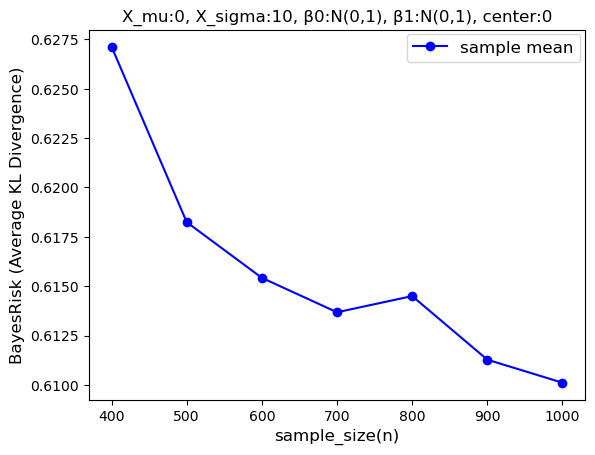

In [4]:
save_dir = make_now_dir("../graph")

# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^NのN)
sample_list = np.linspace(100,1000,10)

# サンプル位置
# サンプル始点
lower = -5
# サンプル終点
upper = 5
center = 0

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001])

# beta0の事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 1000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[3, 0], [0, 3]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)

# KL格納リスト

KL_matrix_sample = np.array([])
KL_matrix_estimator = np.array([])

for beta0,beta1 in tqdm(beta_list):

        # \tilde{D}^Nの生成
        df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

        # Zの生成
        df_z1 = sampler_proba(df, np.array([center, 1]))

        # Z=1のみに絞る
        df_z1 = df.loc[df["Z"]==1]

        # 真のp計算
        p_true = df["Y"].mean() 

        # サンプルサイズごとに計算
        for sample in sample_list:

            # D^nの生成
            df_sample = df_z1[:sample.astype(int)]

            # 標本平均
            p_sample = df_sample["Y"].mean()
            KL_matrix_sample = np.append(KL_matrix_sample, KLD(p_sample,p_true))

# KL行列を変形
KL_matrix_sample_t = KL_matrix_sample.reshape(len(beta_list),len(sample_list))

# KL行列を平均
KL_mean_sample = np.mean(KL_matrix_sample_t,axis=0)

# グラフ描画
plt.plot(sample_list, KL_mean_sample, label="sample mean", color = "blue",marker='.',markersize=12)

plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(0,1), center:{}".format(X_mu, X_sigma,round(center,3)), fontsize = 12)
plt.xlabel("sample_size(n)", fontsize = 12)
plt.ylabel("BayesRisk (Average KL Divergence)", fontsize = 12)

plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         
 
plt.savefig("{}/BayesRisk-by-sample-size_sample-mean_Xmu_{}_Xsigma_{}.png".format(save_dir,X_mu,X_sigma))       

最尤推定

In [ ]:
# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^NのN)
sample_list = np.linspace(100,1000,10)

# サンプル位置
# サンプル始点
lower = -5
# サンプル終点
upper = 5
center = 0

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001])

# beta0の事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 1000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[1, 0], [0, 1]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)

# KL格納リスト

KL_matrix_sample = np.array([])
KL_matrix_estimator = np.array([])

# center
center = 0

for beta0,beta1 in tqdm(beta_list):

        # \tilde{D}^Nの生成
        df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

        # Zの生成
        df_z1 = sampler_proba(df, np.array([center, 0.5]))

        # 真のp計算
        p_true = df["Y"].mean() 

        # サンプルサイズごとに計算
        for sample in sample_list:

            # D^nの生成
            df_sample = df_z1[:sample.astype(int)]

            # D^nによるBOE
            beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
            X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
            p_estimator_all = sigmoid(X_true, beta_posterior)
            p_estimator = np.mean(p_estimator_all)
            KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

# KL行列を変形
KL_matrix_estimator_t = KL_matrix_estimator.reshape(len(beta_list),len(sample_list))

# KL行列を平均
KL_mean_estimator = np.mean(KL_matrix_estimator_t,axis=0)

# グラフ描画
plt.plot(sample_list, KL_mean_estimator, label="Proposed method", color = "red",marker='.',markersize=12)

plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(0,1), center:{}".format(X_mu, X_sigma,round(center,3)), fontsize = 12)
plt.xlabel("sample_size(n)", fontsize = 12)
plt.ylabel("BayesRisk (Average KL Divergence)", fontsize = 12)

plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

save_dir = make_now_dir("../graph")
 
plt.savefig("{}/BayesRisk-by-sample-size_Xmu_{}_Xsigma_{}.png".format(save_dir,X_mu,X_sigma))       

提案手法

  0%|                                                   | 0/100 [00:00<?, ?it/s]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
  3%|█▏                                       | 3/100 [02:34<1:35:35, 59.13s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
  5%|██                                       | 5/100 [03:51<1:18:44, 49.73s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
  6%|██▌                                        | 6/100 [03:59<55:33, 35.47s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
  7%|███                                        | 7/100 [04:06<40:50, 26.35s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/funct

 77%|████████████████████████████████▎         | 77/100 [51:31<22:28, 58.62s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
 78%|████████████████████████████████▊         | 78/100 [51:39<15:53, 43.32s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
 80%|█████████████████████████████████▌        | 80/100 [52:58<14:46, 44.31s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
 83%|██████████████████████████████████▊       | 83/100 [55:29<14:59, 52.89s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/function.py:29: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-input))
 84%|███████████████████████████████████▎      | 84/100 [55:37<10:28, 39.30s/it]/Users/abetaichi/保管用/大学院/研究室/研究/選択バイアス補正/code/funct

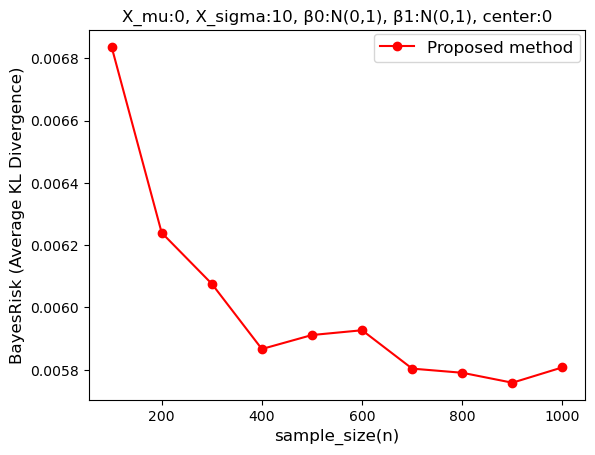

In [18]:
# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^NのN)
sample_list = np.linspace(100,1000,10)

# サンプル位置
# サンプル始点
lower = -5
# サンプル終点
upper = 5
center = 0

# windowサイズ
window = 5

# betaの事前分布平均
beta_prior_mu = np.array([0.001,0.001])

# beta0の事前分布ノイズ
beta_prior_var = np.array([[100,0],[0,100]])

# バーンイン
burn = 1000

# ドロー
draw = 5000

# 期待値計算のためにβを乱数生成

Ex_num = 100
beta_mean = np.array([0, 1])
beta_cov = np.array([[1, 0], [0, 1]])
beta_list = np.random.multivariate_normal(beta_mean, beta_cov, size=Ex_num)

# KL格納リスト

KL_matrix_sample = np.array([])
KL_matrix_estimator = np.array([])

# center
center = 0

for beta0,beta1 in tqdm(beta_list):

        # \tilde{D}^Nの生成
        df = genarator_norm(X_mu, X_sigma, np.array([beta0, beta1]), 10000)

        # Zの生成
        df_z1 = sampler_proba(df, np.array([center, 0.5]))

        # 真のp計算
        p_true = df["Y"].mean() 

        # サンプルサイズごとに計算
        for sample in sample_list:

            # D^nの生成
            df_sample = df_z1[:sample.astype(int)]

            # D^nによるBOE
            beta_posterior = sample_polya_gamma(df_sample, beta_prior_mu, beta_prior_var, burn, draw)
            X_true = np.random.normal(loc = X_mu, scale = X_sigma , size = draw)
            p_estimator_all = sigmoid(X_true, beta_posterior)
            p_estimator = np.mean(p_estimator_all)
            KL_matrix_estimator = np.append(KL_matrix_estimator, KLD(p_estimator,p_true))

# KL行列を変形
KL_matrix_estimator_t = KL_matrix_estimator.reshape(len(beta_list),len(sample_list))

# KL行列を平均
KL_mean_estimator = np.mean(KL_matrix_estimator_t,axis=0)

# グラフ描画
plt.plot(sample_list, KL_mean_estimator, label="Proposed method", color = "red",marker='.',markersize=12)

plt.title("X_mu:{:}, X_sigma:{:}, β0:N(0,1), β1:N(0,1), center:{}".format(X_mu, X_sigma,round(center,3)), fontsize = 12)
plt.xlabel("sample_size(n)", fontsize = 12)
plt.ylabel("BayesRisk (Average KL Divergence)", fontsize = 12)

plt.legend(bbox_to_anchor=(0.99, 0.99), loc='upper right', borderaxespad=0, fontsize=12)                         

save_dir = make_now_dir("../graph")
 
plt.savefig("{}/BayesRisk-by-sample-size_Xmu_{}_Xsigma_{}.png".format(save_dir,X_mu,X_sigma))       

# Appendix

In [2]:
def sampler_proba(df, beta):

    Z_proba = sigmoid(df["X"], beta)
    Z = stats.bernoulli.rvs(p=Z_proba, size=len(df["X"]))
    df["Z"] = Z
    df_sample = df.loc[df["Z"] == 1]
    return df_sample

In [4]:
# X_mu
X_mu = 0

# X_sigma
X_sigma = 10

# sample size(\tilde{D}^nのn)
sample = 100

df = genarator_norm(X_mu, X_sigma, np.array([0, 1]), 10000)

In [5]:
df

,X,Y
0,6.030856,1.0
1,10.334006,1.0
2,-14.414066,0.0
3,6.763579,1.0
4,8.006765,1.0
...,...,...
9995,1.231978,1.0
9996,11.122868,1.0
9997,-0.216276,0.0
9998,-2.725389,0.0


In [12]:
Z_proba = sigmoid(df["X"], np.array([5, 2]))
Z = stats.bernoulli.rvs(p=Z_proba, size=len(df["X"]))
Z
df["Z"] = Z
df_sample = df.loc[df["Z"] == 1]

In [14]:
df_sample["Z"].value_counts()

1    6020
Name: Z, dtype: int64

In [6]:
sampler_proba(df,np.array[5, 2])

TypeError: 'builtin_function_or_method' object is not subscriptable

In [11]:
x = np.random.normal(loc = 0, scale = 10 , size = 10)

np.stack([np.ones(len(x)), x],axis=1)

array([[  1.        ,  -7.14448565],
       [  1.        ,   6.16281595],
       [  1.        ,   4.70401547],
       [  1.        ,  -2.93113093],
       [  1.        ,   9.89200562],
       [  1.        , -23.12676037],
       [  1.        ,  -2.72000311],
       [  1.        ,  23.70369554],
       [  1.        ,  10.33458147],
       [  1.        ,  11.35034899]])